# MNIST GAN from Scratch (with GPU Acceleration)
## Objective:
To demonstrate the power of GPU-accelerated parallel processing using a Generative Adversarial Network (GAN) trained on the MNIST dataset. We'll generate synthetic images of handwritten digits.

## Setup
We will use TensorFlow which automatically utilizes the GPU if any

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
# Create output directory for images
if not os.path.exists("gan_images"):
    os.makedirs("gan_images")

# Load and preprocess the data
def load_data():
    (X_train, _), (_, _) = mnist.load_data()
    # Normalize and reshape
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    return X_train


## Generator Model

In [5]:
def build_generator(latent_dim=100):
    model = Sequential([
        # First layer
        Dense(256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        # Second layer
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        # Third layer
        Dense(1024),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),

        # Output layer
        Dense(28*28*1, activation='tanh'),
        Reshape((28, 28, 1))
    ])

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

## Discriminator Model

In [6]:
# Build the discriminator network
def build_discriminator(img_shape=(28, 28, 1)):
    model = Sequential([
        Flatten(input_shape=img_shape),
        Dense(512),
        LeakyReLU(alpha=0.2),

        Dense(256),
        LeakyReLU(alpha=0.2),

        Dense(1, activation='sigmoid')
    ])

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

## Train Loop

In [8]:
# Function to sample images and visualize them
def sample_images(generator, epoch, latent_dim=100):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(15, 15))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    fig.savefig(f"gan_images/mnist_{epoch}.png")
    plt.close()

In [9]:
# Improved GAN training class using custom training loop
class MNIST_GAN:
    def __init__(self, latent_dim=100):
        self.img_shape = (28, 28, 1)
        self.latent_dim = latent_dim

        # Build and compile discriminator
        self.discriminator = build_discriminator(self.img_shape)
        self.discriminator.compile(
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Build generator
        self.generator = build_generator(self.latent_dim)

        # For the combined model, we only train the generator
        self.discriminator.trainable = False

        # Build the combined model
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(
            optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy'
        )

        # Initialize history
        self.history = {
            'd_loss': [], 'd_acc': [], 'g_loss': []
        }

    def train(self, X_train, epochs, batch_size, sample_interval=1000, save_interval=5000):
        # Label smoothing values
        real_label_value = 0.9
        fake_label_value = 0.1

        # Adversarial ground truths
        valid = np.ones((batch_size//2, 1))
        fake = np.zeros((batch_size//2, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size//2)
            imgs = X_train[idx]

            # Add noise to real images
            imgs_noisy = imgs + np.random.normal(0, 0.1, imgs.shape)
            imgs_noisy = np.clip(imgs_noisy, -1, 1)

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (batch_size//2, self.latent_dim))
            gen_imgs = self.generator.predict(noise, verbose=0)

            # Apply label smoothing
            valid_smooth = valid * real_label_value
            fake_smooth = fake + fake_label_value

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs_noisy, valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Generate a batch of noise
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)) * real_label_value)

            # Update history
            self.history['d_loss'].append(d_loss[0])
            self.history['d_acc'].append(d_loss[1])
            self.history['g_loss'].append(g_loss)

            # Print progress
            print_interval = max(1, min(100, epochs // 20))
            if epoch % print_interval == 0:
                print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

            # Save sample images
            if epoch % sample_interval == 0:
                sample_images(self.generator, epoch, self.latent_dim)

            # Save models
            if epoch % save_interval == 0 and epoch > 0:
                self.save_models(epoch)

            # Learning rate decay (using callbacks would be cleaner but this works)
            if epoch % 1000 == 0 and epoch > 0:
                # Manually decay learning rates
                d_lr = self.discriminator.optimizer.learning_rate.numpy()
                g_lr = self.combined.optimizer.learning_rate.numpy()

                # Apply decay factor
                self.discriminator.optimizer.learning_rate = d_lr * 0.95
                self.combined.optimizer.learning_rate = g_lr * 0.95

    def save_models(self, epoch):
        self.generator.save(f"generator_epoch_{epoch}.keras")
        self.discriminator.save(f"discriminator_epoch_{epoch}.keras")

    def plot_history(self):
        plt.figure(figsize=(12, 5))

        # Plot discriminator metrics
        plt.subplot(1, 2, 1)
        plt.plot(self.history['d_loss'], label='Discriminator Loss')
        plt.plot(self.history['d_acc'], label='Discriminator Accuracy')
        plt.title('Discriminator Performance')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot generator loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['g_loss'], label='Generator Loss')
        plt.title('Generator Performance')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.savefig('gan_training_history.png')
        plt.show()

## Lift off>>>>>

11493376/11490434 [==============================] - 2s 0us/step
Epoch 0/5000 [D loss: 0.8837, acc: 0.00%] [G loss: 0.8886]
Epoch 100/5000 [D loss: 0.3318, acc: 0.00%] [G loss: 1.9608]
Epoch 200/5000 [D loss: 0.3304, acc: 0.00%] [G loss: 2.1073]
Epoch 300/5000 [D loss: 0.3723, acc: 0.00%] [G loss: 2.0187]
Epoch 400/5000 [D loss: 0.4036, acc: 0.00%] [G loss: 1.5588]
Epoch 500/5000 [D loss: 0.6851, acc: 0.00%] [G loss: 1.1659]
Epoch 600/5000 [D loss: 0.7212, acc: 0.00%] [G loss: 0.7188]
Epoch 700/5000 [D loss: 0.6616, acc: 0.00%] [G loss: 0.7623]
Epoch 800/5000 [D loss: 0.6169, acc: 0.00%] [G loss: 0.7784]
Epoch 900/5000 [D loss: 0.6613, acc: 0.00%] [G loss: 0.7602]
Epoch 1000/5000 [D loss: 0.6923, acc: 0.00%] [G loss: 0.8204]
Epoch 1100/5000 [D loss: 0.6769, acc: 0.00%] [G loss: 0.7947]
Epoch 1200/5000 [D loss: 0.6218, acc: 0.00%] [G loss: 0.8184]
Epoch 1300/5000 [D loss: 0.6465, acc: 0.00%] [G loss: 0.8617]
Epoch 1400/5000 [D loss: 0.6181, acc: 0.00%] [G loss: 0.7848]
Epoch 1500/5000 [

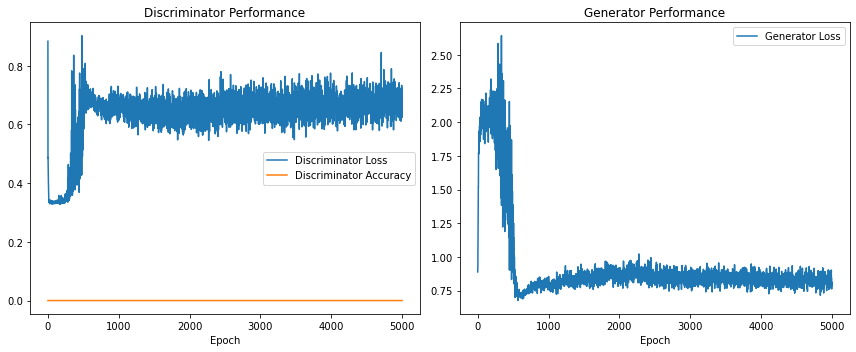

GAN training complete!


In [10]:
# Main execution
if __name__ == "__main__":
    # Load data
    X_train = load_data()

    # Initialize GAN
    gan = MNIST_GAN(latent_dim=100)

    # Training parameters
    epochs = 5000
    batch_size = 32
    sample_interval = 500
    save_interval = 1000

    # Train the GAN
    gan.train(
        X_train=X_train,
        epochs=epochs,
        batch_size=batch_size,
        sample_interval=sample_interval,
        save_interval=save_interval
    )

    # Plot training history
    gan.plot_history()

    # Generate final images
    sample_images(gan.generator, "final")

    # Save final models
    gan.generator.save("generator_final.keras")
    gan.discriminator.save("discriminator_final.keras")

    print("GAN training complete!")